In [1]:
import deepmatcher as dm
from utilities_functions.intermediate_layer_extraction import return_layer_input_output
import torch

torch.cuda.is_available()

True

In [2]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('models/hybrid2.pth')
hybrid_model.cuda()

MatchingModel(
  (attr_summarizers): ModuleMap(
    (Song_Name): Hybrid(
      (word_contextualizer): RNN(
        (rnn_groups): ModuleList(
          (0): GRU(300, 150, batch_first=True, bidirectional=True)
        )
        (dropouts): ModuleList(
          (0): Dropout(p=0)
        )
        (bypass_networks): ModuleList(
          (0): None
        )
        (input_dropout): NoMeta(
          (module): Dropout(p=0)
        )
      )
      (word_comparator): Attention(
        (alignment_networks): ModuleList(
          (0): AlignmentNetwork(
            (transform): Transform(
              (transforms): ModuleList(
                (0): Linear(in_features=300, out_features=300, bias=True)
                (1): Linear(in_features=300, out_features=300, bias=True)
              )
              (bypass_networks): ModuleList(
                (0): Bypass(
                  (highway_gate): Linear(in_features=300, out_features=300, bias=True)
                )
                (1): Bypass(


## Datasets creation

In [3]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

In [4]:
neg_classifier_inputs,neg_classifier_outputs,neg_ids = return_layer_input_output('sample_data/itunes-amazon/'
                                                                         ,'test_negatives.csv',32,hybrid_model,
                                                                        hybrid_model.classifier)

In [5]:
pos_classifier_inputs,pos_classifier_outputs,pos_ids = return_layer_input_output('sample_data/itunes-amazon/',
                                                                       'test_positives.csv',32,hybrid_model,
                                                                       hybrid_model.classifier)

In [6]:
negative_classifier_inputs = list(map(lambda x: x[0],neg_classifier_inputs))
positive_classifier_inputs = list(map(lambda x: x[0],pos_classifier_inputs))

## Utility methods

In [8]:
from utilities_functions.ri_calculator import find_smallest_variation_to_change

## Negative sample analysis

In [10]:
attribute_lenght= len(attributes)

current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri_matrix = []
for batch in negative_classifier_inputs:
    for index in range(len(batch)):
        current_sample_ris = []
        for j,attribute in enumerate(attributes):
            print('Processing sample {} with attribute {}'.format(current_sample,attribute))
            it,variation = find_smallest_variation_to_change(hybrid_model.classifier,1200,150,batch,index,[j],1)
            current_sample_ris.append(variation)
        negatives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample 0 with attribute Song_Name
Processing sample 0 with attribute Artist_Name
Processing sample 0 with attribute Album_Name
Processing sample 0 with attribute Genre
Processing sample 0 with attribute Price
Processing sample 0 with attribute CopyRight
Processing sample 0 with attribute Time
Processing sample 0 with attribute Released
Processing sample 1 with attribute Song_Name
Processing sample 1 with attribute Artist_Name
Processing sample 1 with attribute Album_Name
Processing sample 1 with attribute Genre
Processing sample 1 with attribute Price
Processing sample 1 with attribute CopyRight
Processing sample 1 with attribute Time
Processing sample 1 with attribute Released
Processing sample 2 with attribute Song_Name
Processing sample 2 with attribute Artist_Name
Processing sample 2 with attribute Album_Name
Processing sample 2 with attribute Genre
Processing sample 2 with attribute Price
Processing sample 2 with attribute CopyRight
Processing sample 2 with attribute Ti

Processing sample 23 with attribute Album_Name
Processing sample 23 with attribute Genre
Processing sample 23 with attribute Price
Processing sample 23 with attribute CopyRight
Processing sample 23 with attribute Time
Processing sample 23 with attribute Released
Processing sample 24 with attribute Song_Name
Processing sample 24 with attribute Artist_Name
Processing sample 24 with attribute Album_Name
Processing sample 24 with attribute Genre
Processing sample 24 with attribute Price
Processing sample 24 with attribute CopyRight
Processing sample 24 with attribute Time
Processing sample 24 with attribute Released
Processing sample 25 with attribute Song_Name
Processing sample 25 with attribute Artist_Name
Processing sample 25 with attribute Album_Name
Processing sample 25 with attribute Genre
Processing sample 25 with attribute Price
Processing sample 25 with attribute CopyRight
Processing sample 25 with attribute Time
Processing sample 25 with attribute Released
Processing sample 26 wi

Processing sample 46 with attribute Album_Name
Processing sample 46 with attribute Genre
Processing sample 46 with attribute Price
Processing sample 46 with attribute CopyRight
Processing sample 46 with attribute Time
Processing sample 46 with attribute Released
Processing sample 47 with attribute Song_Name
Processing sample 47 with attribute Artist_Name
Processing sample 47 with attribute Album_Name
Processing sample 47 with attribute Genre
Processing sample 47 with attribute Price
Processing sample 47 with attribute CopyRight
Processing sample 47 with attribute Time
Processing sample 47 with attribute Released
Processing sample 48 with attribute Song_Name
Processing sample 48 with attribute Artist_Name
Processing sample 48 with attribute Album_Name
Processing sample 48 with attribute Genre
Processing sample 48 with attribute Price
Processing sample 48 with attribute CopyRight
Processing sample 48 with attribute Time
Processing sample 48 with attribute Released
Processing sample 49 wi

Processing sample 69 with attribute Album_Name
Processing sample 69 with attribute Genre
Processing sample 69 with attribute Price
Processing sample 69 with attribute CopyRight
Processing sample 69 with attribute Time
Processing sample 69 with attribute Released
Processing sample 70 with attribute Song_Name
Processing sample 70 with attribute Artist_Name
Processing sample 70 with attribute Album_Name
Processing sample 70 with attribute Genre
Processing sample 70 with attribute Price
Processing sample 70 with attribute CopyRight
Processing sample 70 with attribute Time
Processing sample 70 with attribute Released
Processing sample 71 with attribute Song_Name
Processing sample 71 with attribute Artist_Name
Processing sample 71 with attribute Album_Name
Processing sample 71 with attribute Genre
Processing sample 71 with attribute Price
Processing sample 71 with attribute CopyRight
Processing sample 71 with attribute Time
Processing sample 71 with attribute Released
Processing sample 72 wi

In [11]:
ri_norms_negative_samples = []
for ri_list in negatives_ri_matrix:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))

In [12]:
import pandas as pd
variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)

In [26]:
ri_sums = variation_df.sum(numeric_only=True)

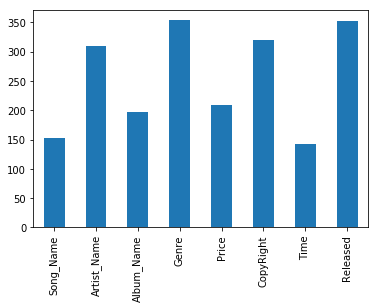

In [27]:
ri_sums.plot.bar()

In [17]:
ri_sums_histogram

,Song_Name,Artist_Name,Album_Name,Genre,Price,CopyRight,Time,Released
0,151.929833,310.025233,196.622381,353.354244,208.192939,319.629959,142.444751,352.49767


In [ ]:
variation_df.to_csv('experiments-results/negative_samples_ri.csv',index=False)

## Positive samples analisys

In [21]:
attribute_lenght= len(attributes)
positive_samples_ri_matrix = []
current_sample = 0

for batch in positive_classifier_inputs:
    for index in range(len(batch)):
        current_sample_ris = []
        for j,attribute in enumerate(attributes):
            print('Processing sample {} with attribute {}'.format(current_sample,attribute))
            it,variation = find_smallest_variation_to_change(hybrid_model.classifier,1200,150,batch,index,[j],0)
            current_sample_ris.append(variation)
        positive_samples_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample 0 with attribute Song_Name
Processing sample 0 with attribute Artist_Name
Processing sample 0 with attribute Album_Name
Processing sample 0 with attribute Genre
Processing sample 0 with attribute Price
Processing sample 0 with attribute CopyRight
Processing sample 0 with attribute Time
Processing sample 0 with attribute Released


KeyboardInterrupt: 

In [16]:
ri_norms = []
for ri_list in positive_samples_ri_matrix:
    ri_norms.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))

In [17]:
import pandas as pd
variation_df = pd.DataFrame(data= ri_norms,columns=attributes)
variation_df.head(10)

,Song_Name,Artist_Name,Album_Name,Genre,Price,CopyRight,Time,Released
0,3.872846,8.319950,4.733742,9.774311,4.501761,9.213081,3.158820,9.139496
1,1.321819,3.063657,1.892720,3.162920,1.857678,3.136400,1.291796,3.141989
2,3.690373,7.226118,4.450614,7.904346,3.722036,7.935526,3.003594,7.286551
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.252825,2.437601,1.294456,2.480936,1.302333,3.039119,1.253855,3.064450
5,6.640363,14.395420,8.308698,14.458667,7.319551,15.160510,5.715682,14.499591
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.535260,0.535260,0.535260,0.535260,0.535260,0.535260,0.535260,0.535260
8,5.833161,12.877977,7.525358,13.852884,6.568400,15.264273,4.946322,13.892619
9,3.893717,8.453933,4.759547,9.940929,4.543568,9.920132,3.208069,9.904309


In [ ]:
variation_df.to_csv('experiments-results/positive_samples_ri_truegradient.csv',index=False,sep=';')

In [18]:
variation_df['Price'].sum()

142.39817982912064

In [19]:
variation_df['Artist_Name'].sum()

270.9511730670929

In [20]:
variation_df['Time'].sum()

108.37522941827774

In [21]:
variation_df['Song_Name'].sum()

122.30956792831421

## Finding closer vectors

In [23]:
from scipy.spatial.distance import euclidean
def get_closer_vector(v,batch_list):
    min_distance = 10000000
    i = 0
    best_sample = i
    for batch in batch_list:
        for sample in batch:
            curr_distance = euclidean(v.data,sample.data)
            if curr_distance< min_distance:
                min_distance = curr_distance
                best_sample = i
            i+=1
    return best_sample

In [24]:
def get_closer_vector_on_attribute(v,batch_list,attribute_idx,attribute_lenght):
    min_distance = 1000000
    i = 0
    best_sample = i
    start_index = attribute_idx*attribute_lenght
    end_index = start_index+attribute_lenght
    v_attribute_selected = v[start_index:end_index]
    for batch in batch_list:
        for sample in batch:
            curr_distance = euclidean(v_attribute_selected.data,sample[start_index:end_index].data)
            if curr_distance < min_distance:
                min_distance = curr_distance
                best_sample = i
            i+=1
    return best_sample

In [25]:
#test
closer_sample_index = get_closer_vector_on_attribute(positive_classifier_inputs[0][10],positive_classifier_inputs,0,150)

In [ ]:
idx = get_closer_vector_on_attribute(positive_classifier_inputs[4][5],negative_classifier_inputs,0,150)

In [ ]:
idx

In [ ]:
positive_batches[4].id

In [ ]:
#lista di tuple: vettore più vicino considerando tutti gli elementi e closer solo secondo un attributo
closer_vectors = []
i = 0
for batch in negative_classifier_inputs:
    for sample in batch:
        # lista di coppie in cui il primo elemento indica il campione più vicino considerando tutti gli elementi
        # e il secondo indica il più vicino considerando il singolo attributo
        current_sample_closer_vectors = []
        for j,attribute in enumerate(attributes):
            curr_ri = negatives_ri_matrix[i][j]
            altered_sample = sample + curr_ri
            closer_index = get_closer_vector(altered_sample,positive_classifier_inputs)
            closer_on_attribute = get_closer_vector_on_attribute(altered_sample,
                                                                               positive_classifier_inputs,j,150)
            current_sample_closer_vectors.append((closer_index,closer_on_attribute))
        closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [ ]:
#lista di tuple: vettore piu' vicino, batch index e sample index
positives_closer_vectors = []
i = 0
for batch in positive_classifier_inputs:
    for sample in batch:
        current_sample_closer_vectors = []
        for j,attribute in enumerate(attributes):
            curr_ri = positive_samples_ri_matrix[i][j]
            altered_sample = sample + curr_ri
            closer_index = get_closer_vector(altered_sample,negative_classifier_inputs)
            closer_on_attribute_index = get_closer_vector_on_attribute(altered_sample,
                                                                               negative_classifier_inputs,j,150)
            current_sample_closer_vectors.append((closer_index,closer_on_attribute_index))
        positives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [ ]:
ordered_id_positives = []
for batch in positive_batches:
    ordered_id_positives = ordered_id_positives+batch.id

In [ ]:
ordered_id_negatives = []
for batch in negative_batches:
    ordered_id_negatives = ordered_id_negatives+batch.id

In [ ]:
closer_vectors[1]

In [ ]:
positives_closer_vectors_df = pd.DataFrame(data= positives_closer_vectors,columns =attributes)

In [ ]:
positives_closer_vectors_df.head()

In [ ]:
negatives_closer_vectors_df = pd.DataFrame(data = closer_vectors, columns = attributes)

In [ ]:
negatives_closer_vectors_df.head()

In [ ]:
positives_closer_vectors_df = positives_closer_vectors_df.applymap(lambda c: (ordered_id_negatives[c[0]],
                                                                   ordered_id_negatives[c[1]]))

In [ ]:
positives_closer_vectors_df.head()

In [ ]:
negatives_closer_vectors_df = negatives_closer_vectors_df.applymap(lambda c: (ordered_id_positives[c[0]],
                                                                   ordered_id_positives[c[1]]))

In [ ]:
negatives_closer_vectors_df.head()

In [ ]:
positives_closer_vectors_on_attribute_df = positives_closer_vectors_df.applymap(lambda c: c[1])

In [ ]:
positives_closer_vectors_on_attribute_df.head()

In [ ]:
negatives_closer_vectors_on_attribute_df = negatives_closer_vectors_df.applymap(lambda c : c[1])

In [ ]:
positives_closer_vectors_df['Pos_sample_ID']= ordered_id_positives
positives_closer_vectors_on_attribute_df['Pos_sample_ID'] = ordered_id_positives

In [ ]:
positives_closer_vectors_df.to_csv('positives_closer_vectors.csv',sep=';',index=False)

In [ ]:
positives_closer_vectors_on_attribute_df.to_csv('positives_closer_vectors_on_attribute.csv',sep=';',index=False)

In [ ]:
negatives_closer_vectors_df['Neg_sample_ID'] = ordered_id_negatives
negatives_closer_vectors_on_attribute_df['Neg_sample_ID'] = ordered_id_negatives

In [ ]:
negatives_closer_vectors_df.to_csv('negatives_closer_vectors.csv',sep=';',index=False)
negatives_closer_vectors_on_attribute_df.to_csv('negatives_closer_vector_on_attribute.csv',sep=';',index=False)

### Some tests

In [ ]:
it,variation = find_smallest_variation_to_change(hybrid_model.classifier,positive_classifier_inputs[0],20,6,0)

In [ ]:
positive_classifier_inputs[0][20].data = positive_classifier_inputs[0][20].data.copy_(positive_classifier_inputs[0][20].data+
                                                                                     variation.data)

In [ ]:
hybrid_model.classifier.forward(positive_classifier_inputs[0])[20]

In [ ]:
grads_list = []
h = positive_classifier_inputs[0].register_hook(lambda g: grads_list.append(g))

In [ ]:
out = hybrid_model.classifier.forward(positive_classifier_inputs[0])
prob = get_probabilites(out[20])

In [ ]:
from torch.autograd import Variable
true_labels = Variable (torch.cuda.FloatTensor([0,1]))